In [29]:
pip show FastKmedoids

Name: FastKmedoidsNote: you may need to restart the kernel to use updated packages.

Version: 0.0.37
Summary: FastKmedoids is a Python package to apply the clustering algorithms Fast Kmedoids and KFold Fast Kmedoids.
Home-page: https://github.com/FabioScielzoOrtiz/FastKmedoids-package
Author: Fabio Scielzo Ortiz
Author-email: fabioscielzo98@gmail.com
License: 
Location: c:\Users\fscielzo\Documents\Proyectos\FastKmedoids\FastKmedoids-demo\.venv\Lib\site-packages
Requires: numpy, polars
Required-by: 


In [30]:
import pandas as pd
import polars as pl
from sklearn.datasets import make_blobs
from FastKmedoids.data import outlier_contamination
from FastKmedoids.models import FastKmedoidsGGower, FastGGowerDistMatrix
from FastKmedoids.plots import clustering_MDS_plot_one_method, clustering_MDS_plot_multiple_methods
from FastKmedoids.metrics import adjusted_accuracy
from sklearn.manifold import MDS
import seaborn as sns
sns.set_style('whitegrid')


In [61]:
X, Y = make_blobs(n_samples=35000, centers=4, cluster_std=[2,2,2,3], n_features=8, random_state=123)
X = pd.DataFrame(X)      
X.columns = [f"X{i}" for i in range(1, X.shape[1]+1)]

# Se convierten dos variables cuantitativas a binarias, y otras dos a multiclase, discretizandolas.
X['X5'] = pd.cut(X['X5'], bins=[X['X5'].min()-1, X['X5'].mean(), X['X5'].max()+1], labels=False)
X['X6'] = pd.cut(X['X6'], bins=[X['X6'].min()-1, X['X6'].mean(), X['X6'].max()+1], labels=False)
X['X7'] = pd.cut(X['X7'], bins=[X['X7'].min()-1, X['X7'].quantile(0.25), X['X7'].quantile(0.50), X['X7'].quantile(0.75), X['X7'].max()+1], labels=False)
X['X8'] = pd.cut(X['X8'], bins=[X['X8'].min()-1, X['X8'].quantile(0.25), X['X8'].quantile(0.50), X['X8'].quantile(0.75), X['X8'].max()+1], labels=False)   

X_outliers, outliers_idx_X1 = outlier_contamination(X, col_name='X1', prop_above=0.1, sigma=3, random_state=123)
X_outliers, outliers_idx_X2 = outlier_contamination(X_outliers, col_name='X2', prop_below=0.1, sigma=5, random_state=123)
X_outliers_pl = pl.from_pandas(X_outliers)
X_not_outliers_pl = pl.from_pandas(X)

X = X_outliers.copy()

In [62]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8
0,-2.651313,0.425178,-4.840969,4.436158,0,0,0,2
1,-41.469161,-47.546455,-0.516458,-1.903982,0,1,0,0
2,6.366665,2.813932,-2.505519,-7.371732,0,1,0,0
3,-5.000105,-7.485500,3.060407,4.966358,0,1,2,1
4,-4.931669,-6.980633,2.779526,-2.976350,1,1,2,2


In [63]:
fast_kmedoids = FastKmedoidsGGower(n_clusters=4, method='pam', init='heuristic', max_iter=100, random_state=111,
                                   frac_sample_size=0.01, p1=4, p2=2, p3=2, 
                                   d1='robust_mahalanobis', d2='jaccard', d3='hamming', 
                                   robust_method='trimmed', alpha=0.05, epsilon=0.05, n_iters=20)

fast_kmedoids.fit(X) 

cluster_labels = fast_kmedoids.labels

In [64]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=111) 

fastGGower = FastGGowerDistMatrix(frac_sample_size=0.03, random_state=111, p1=4, p2=2, p3=2, 
                                  d1='robust_mahalanobis', d2='sokal', d3='hamming', 
                                  robust_method='winsorized', alpha=0.08)

fastGGower.compute(X)

D_GGower = fastGGower.D_GGower

X_mds = mds.fit_transform(D_GGower)

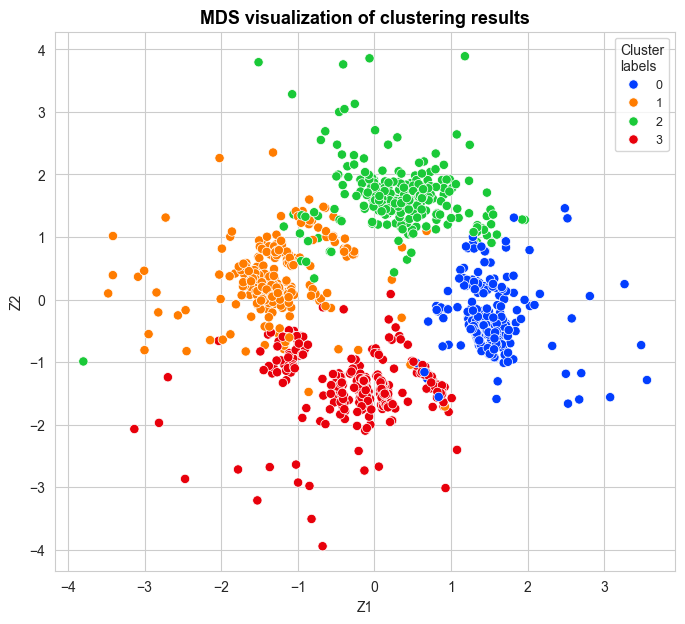

In [65]:
clustering_MDS_plot_one_method(X_mds=X_mds, y_pred=cluster_labels[fastGGower.sample_index], 
                               y_true=None, title="MDS visualization of clustering results", 
                               accuracy=None, time=None, 
                               figsize=(8,7), bbox_to_anchor=(1,1), 
                               title_size=13, title_weight='bold', 
                               points_size=45, title_height=1, 
                               save=False, legend_size=9)


In [66]:
adj_accuracy, adj_cluster_labels = adjusted_accuracy(y_pred=cluster_labels, y_true=Y)

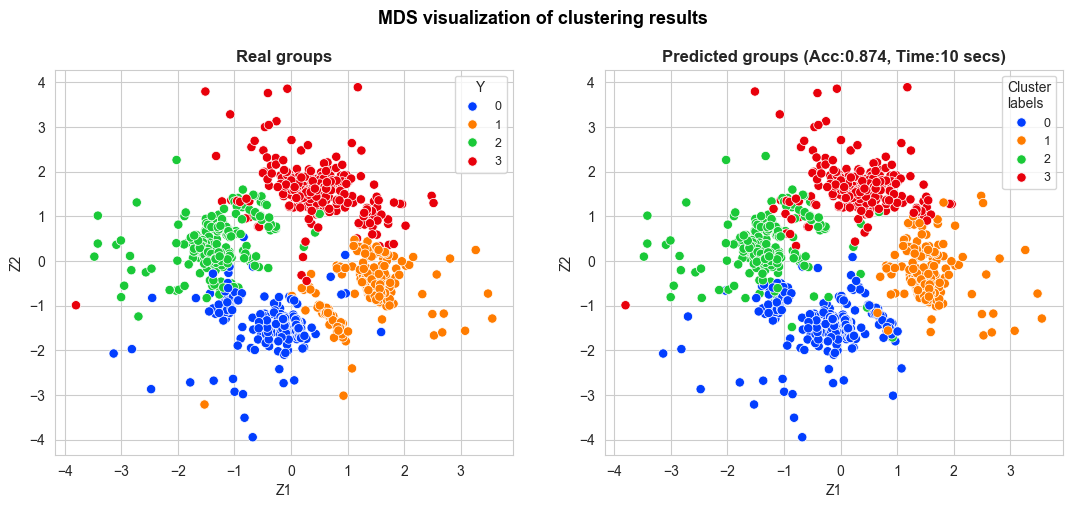

In [67]:
clustering_MDS_plot_one_method(X_mds=X_mds, 
                               y_pred=adj_cluster_labels[fastGGower.sample_index], 
                               y_true=Y[fastGGower.sample_index],
                               title="MDS visualization of clustering results", 
                               accuracy=adj_accuracy, time=10, 
                               figsize=(13,5), bbox_to_anchor=(1,1), 
                               title_size=13, title_weight='bold', 
                               points_size=45, title_height=1, 
                               save=False, legend_size=9, wspace=0.2)


In [68]:
fast_kmedoids_euclidean = FastKmedoidsGGower(n_clusters=4, method='pam', init='heuristic', 
                                             max_iter=100, random_state=111,
                                             frac_sample_size=0.01, p1=4, p2=2, p3=2, 
                                             d1='euclidean', d2='jaccard', d3='hamming', 
                                             robust_method='trimmed', alpha=0.08, 
                                             epsilon=0.05, n_iters=20)

fast_kmedoids_euclidean.fit(X) 

cluster_labels_euclidean = fast_kmedoids_euclidean.labels

In [69]:
adj_accuracy_euclidean, adj_cluster_labels_euclidean = adjusted_accuracy(y_pred=cluster_labels_euclidean, y_true=Y)

In [70]:
y_pred = {'euclidean': adj_cluster_labels_euclidean[fastGGower.sample_index],
          'robust_mahalanobis': adj_cluster_labels[fastGGower.sample_index]}

In [71]:
accuracy = {'euclidean': adj_accuracy_euclidean,
            'robust_mahalanobis': adj_accuracy}

In [72]:
time_euclidean = 10
time_robust_maha = 30
time = {'euclidean': time_euclidean,
            'robust_mahalanobis': time_robust_maha}

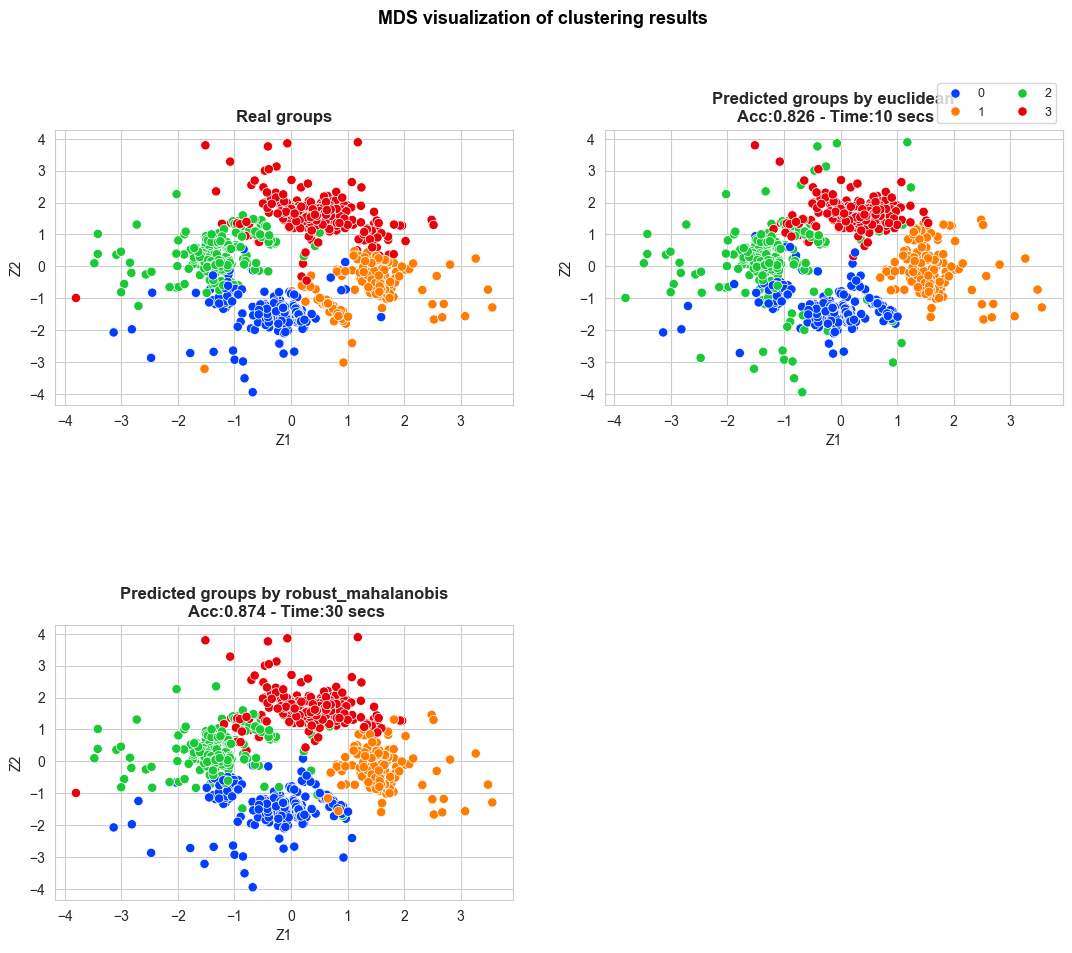

In [73]:
clustering_MDS_plot_multiple_methods(X_mds=X_mds, 
                                     y_pred=y_pred, 
                                     y_true=Y[fastGGower.sample_index],
                                     title="MDS visualization of clustering results", 
                                     accuracy=accuracy, time=time, 
                                     figsize=(13,10), bbox_to_anchor=(1,1), 
                                     title_size=13, title_weight='bold', 
                                     points_size=45, title_height=1, 
                                     save=False, legend_size=9, wspace=0.2)


TO DO

- add kmeans, GMM and classic kmedoids to the plot
- remove faskmeids euclidean